Predicting Runs Scored - The First Model

    - We will now use the data frame from before to build a model to predict the distribution of runs scored

    - We will use an algorithm called Coarsage to model these distributions (Coarsage is in the StructureBoost package)

    - Coarsage is similar to PrestoBoost (a paper on PrestoBoost can be found here: https://arxiv.org/abs/2210.16247)

    - But it is a bit cleaner (needs only a single forest)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import structureboost as stb
import ml_insights as mli

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
# need to have StructureBoost >= 0.4.0

stb.__version__

'0.4.3'

In [3]:
df = pd.read_csv('df_bp9.csv', low_memory=False)

df_runs = pd.read_csv('df_runs_bp11.csv', low_memory=False)

In [4]:
df.over_under_line.max()

15.0

In [5]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],15)

In [6]:
df_train = df_runs[(df_runs.season>1970) & (df_runs.season<=2015) & ~(df_runs.OBP_162.isnull())]
df_valid = df_runs[(df_runs.season>=2016) & (df_runs.season<=2020)]
df_test = df_runs[df_runs.season>=2021]

In [7]:
df_test_game = df[df.season>=2021]

BEGIN MODELING

In [8]:
df_runs.head(10)

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc
0,1970,19700406,0,197004060,WS2,DET,AL,AL,0.0,NaN,WAS10,D,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.262702,0.244266,0.261798,0.245791,0.338739,0.322035,0.338695,0.324118,0.394825,0.363500,0.392347,0.365242,0.733564,0.685536,0.731041,0.689360,0.364310,0.376972,0.365211,0.376176,0.146619,0.170586,0.147911,0.168707,0.267313,0.245760,0.266452,0.247721,0.342759,0.318749,0.342771,0.321810,0.391202,0.357365,0.390137,0.360702,0.733961,0.676114,0.732908,0.682512,0.342746,0.340960,0.344454,0.342728,0.130900,0.145244,0.131845,0.144275,0.261027,0.238197,0.260954,0.241031,0.335281,0.307287,0.335944,0.311442,0.389124,0.353090,0.389167,0.357706,0.724405,0.660376,0.725110,0.669148,0.346366,0.327429,0.347829,0.331155,0.133906,0.134460,0.134516,0.134940,0.230243,0.207518,0.228410,0.208750,0.294839,0.266365,0.293402,0.268685,0.341378,0.306780,0.339530,0.309508,0.636217,0.573145,0.632933,0.578193,0.318284,0.291967,0.318138,0.295178,0.134130,0.126369,0.133713,0.126979,3.923077,1.320513,0.214286,0.306548,0.431548,3.615385,0.839286,3.174505,1.206683,0.232950,0.287865,0.385297,2.680693,0.639504,3.123067,1.149966,0.227472,0.277642,0.379445,2.693342,0.650268,1.5,0.200000,0.370000,0.4500,1.5,0.200000,0.370000,0.450000,1.5,0.200000,0.370000,0.450,1,0
1,1970,19700406,0,197004060,CIN,MON,NL,NL,0.0,NaN,CIN07,D,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202226,0.194571,0.209172,0.201816,0.240675,0.

In [9]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_TB_BB_perc_35',
 'Strt_H_BB_perc_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_TB_BB_perc_75',
 'Bpen_H_BB_perc_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35',
 'Bpen_TB_BB_perc_35',
 'Bpen_H_BB_perc_35',
 'Bpen_SO_perc_35',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']

In [10]:
bpv2 = np.linspace(-.5,15.5,17)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5])

In [11]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [12]:
cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.465236195961687
i=10, eval_set_loss = 2.4620418753992985
i=20, eval_set_loss = 2.459824525320622
i=30, eval_set_loss = 2.4579933832939025
i=40, eval_set_loss = 2.456561669117958
i=50, eval_set_loss = 2.455562658064318
i=60, eval_set_loss = 2.454940121869388
i=70, eval_set_loss = 2.454359840248607
i=80, eval_set_loss = 2.4536305618194465
i=90, eval_set_loss = 2.4531065340764995
i=100, eval_set_loss = 2.452680869584473
i=110, eval_set_loss = 2.4523397864252585
i=120, eval_set_loss = 2.452141228731427
i=130, eval_set_loss = 2.4519698796019918
i=140, eval_set_loss = 2.4518154799479883
i=150, eval_set_loss = 2.4516865574981215
i=160, eval_set_loss = 2.4516805956907604
i=170, eval_set_loss = 2.4517207727193657
i=180, eval_set_loss = 2.4516528981333665
i=190, eval_set_loss = 2.451647818976384
i=200, eval_set_loss = 2.4516916023747872
i=210, eval_set_loss = 2.4517712971014682
i=220, eval_set_loss = 2.4518280928310348
i=230, eval_set_loss = 2.451857137430483
i=240, eval_s

In [13]:
preds_test = cr1.predict_distributions(X_test)

In [14]:
preds_test.log_loss(y_test)

2.4214998708657562

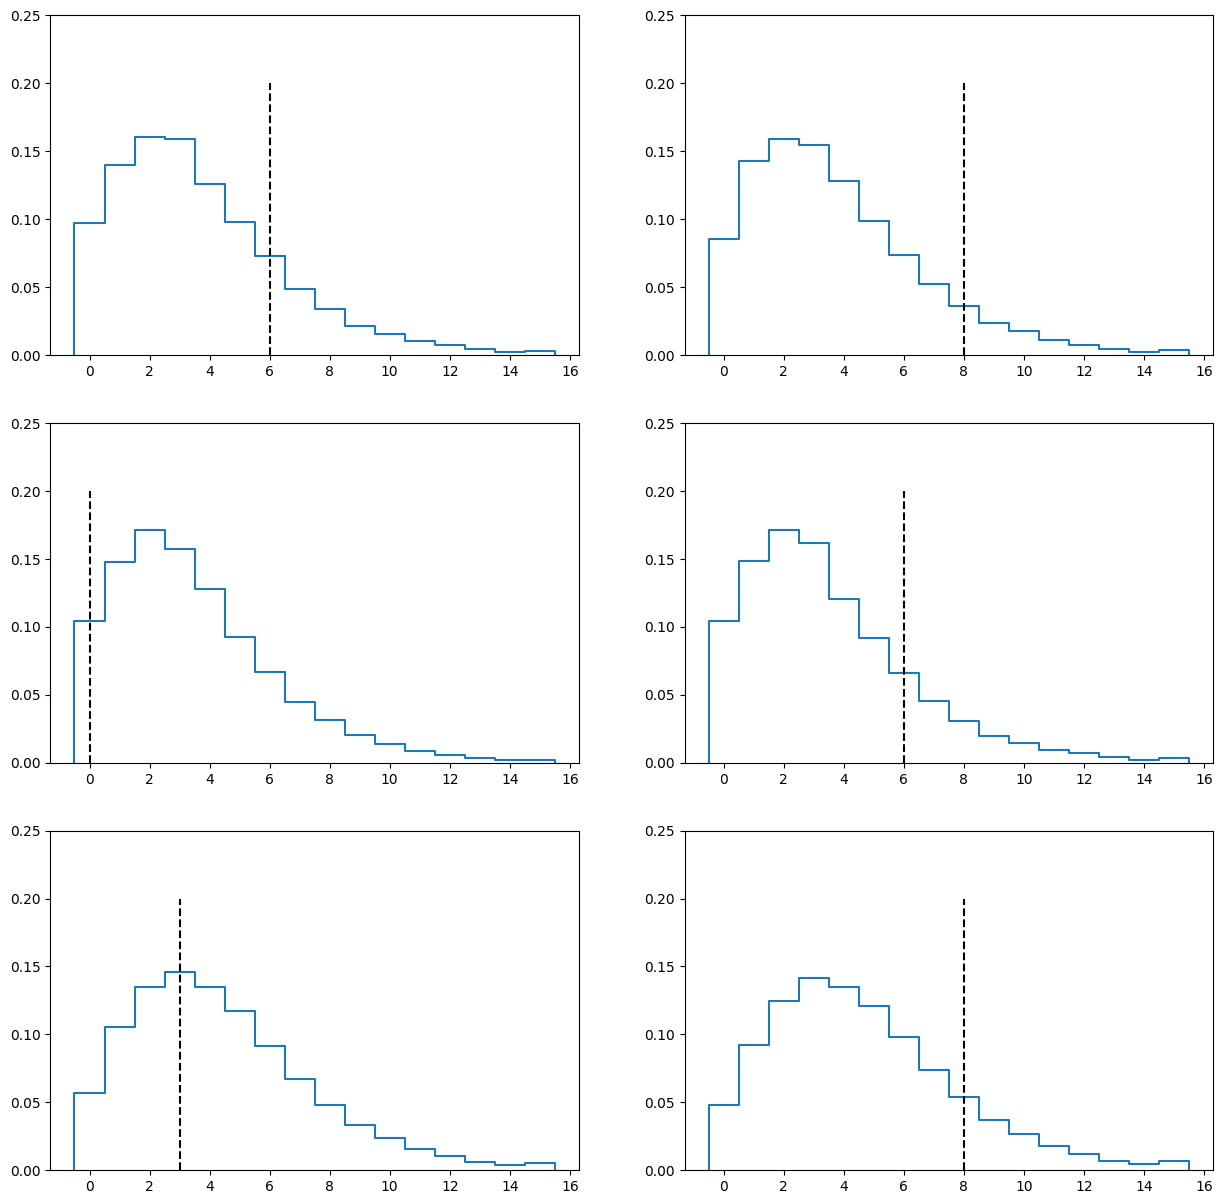

In [15]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    preds_test[i].plot_density()
    plt.ylim([0,.25])
    plt.vlines(x=y_test[i], ymin=0,ymax=.2, color='k', linestyle='--')

Next Steps

    - Using these probability distributions, we can now predict the distribution of total number of runs scored (by adding together the two distributions)

    - Using that, we can come up with probabilities on whether the total number of runs exceeds the over/under line